In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

In [16]:
NB_NODES = 50
DURATION = 10000   # Nb samples
REVOLUTION = 1800  # Nb samples
SAMPLE_FREQ = 0.1  # Hz, 1 sample every 10 seconds
CONNECTION_RANGE = 30000 # m

# Variables globales pour l'analyse
SAMPLE_STEP = 12
NB_REPETITIONS = 30

# Variables globales figures
TMAX = REVOLUTION/SAMPLE_FREQ
IDX = np.arange(0, TMAX, (1/SAMPLE_FREQ)*SAMPLE_STEP) # conversion en secondes

In [78]:
df_ref = pd.read_csv('..\output\data\sat50_reliability_undivided_sampled12.csv' , sep=',', index_col='Unnamed: 0')
df_ref = df_ref.set_index('Timestamp')
df_ref

,RFlow,RCost,Efficiency,Redundancy,Disparity,Criticity
Timestamp,,,,,,
0,1.0,8734,0.459133,3.888163,0.288980,12
12,1.0,8824,0.458643,3.877551,0.292381,13
24,1.0,8672,0.456952,4.216327,0.296465,14
36,1.0,8616,0.470500,3.360816,0.248742,11
48,1.0,9024,0.410649,4.475102,0.333679,18
...,...,...,...,...,...,...
1740,1.0,9200,0.421857,4.953469,0.339085,19
1752,1.0,8806,0.425260,4.457143,0.327870,17
1764,1.0,8720,0.440979,4.564898,0.292327,12


In [79]:
df_rnd = pd.read_csv('..\output\data\sat50_reliability_RND_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_mirw = pd.read_csv('..\output\data\sat50_reliability_MIRW_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_ffd = pd.read_csv('..\output\data\sat50_reliability_FFD_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_kmeans = pd.read_csv('..\output\data\sat50_reliability_KMeans_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')

df_rnd = df_rnd.groupby('Timestamp').mean()
df_mirw = df_mirw.groupby('Timestamp').mean()
df_ffd = df_ffd.groupby('Timestamp').mean()
df_kmeans = df_kmeans.groupby('Timestamp').mean()

df_kmeans.head()

,RFlow,RCost,Efficiency,Redundancy,Disparity,Criticity
Timestamp,,,,,,
0,1.0,397.200000,0.783116,1.352292,0.146330,2.166667
12,1.0,395.333333,0.782039,1.372822,0.176448,2.166667
24,1.0,403.600000,0.780234,1.405983,0.187879,2.300000
36,1.0,412.666667,0.772800,1.355545,0.180456,3.166667
48,1.0,433.600000,0.748511,1.421708,0.185554,3.666667


In [80]:
ref_rcost_avg = df_ref['RCost'].mean()
print('Coût de routage moyen dans le graphe original:', int(ref_rcost_avg), 'transmissions')

Coût de routage moyen dans le graphe original: 8171 transmissions


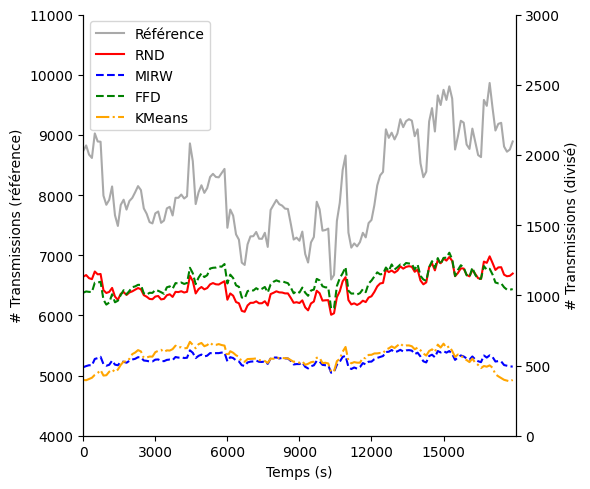

In [136]:
fig, ax = plt.subplots(figsize=(6,5))
metric = 'RCost'

l1 = ax.plot(IDX, df_ref[metric], label='Référence', c='darkgray')
ax.set_xlabel('Temps (s)')
ax.set_ylabel('# Transmissions (référence)', color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.set_xlim(0,TMAX)
ax.set_ylim(4000, 11000)
ax.spines['top'].set_visible(False)
ax.set_xticks(np.arange(0, TMAX, 3000))

ax2 = ax.twinx()
l2 = ax2.plot(IDX, df_rnd[metric], '-r', label='RND')
l3 = ax2.plot(IDX, df_mirw[metric], '--b', label='MIRW')
l4 = ax2.plot(IDX, df_ffd[metric], '--g', label='FFD')
l5 = ax2.plot(IDX, df_kmeans[metric], ls='-.', c='orange', label='KMeans')

ax2.set_ylabel('# Transmissions (divisé)', color='black')
ax2.set_ylim(0, 3000)
ax2.tick_params(axis='y', labelcolor='black')
ax2.spines['top'].set_visible(False)

lns = l1 + l2 + l3 + l4 + l5
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc='upper left')
fig.tight_layout()

(0.0, 28.0)

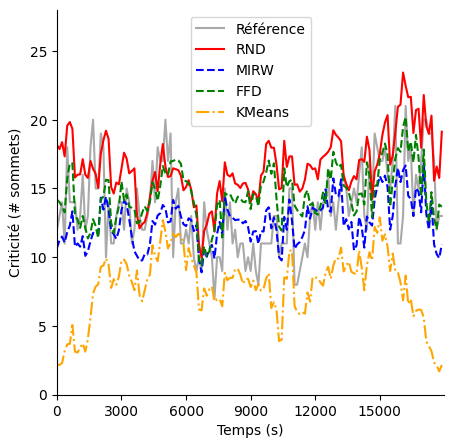

In [131]:
fig,ax = plt.subplots(figsize=(5,5))
metric = 'Criticity'

ax.plot(IDX, df_ref[metric], c='darkgray', label='Référence')
ax.plot(IDX, df_rnd[metric], '-r', label='RND')
ax.plot(IDX, df_mirw[metric], '--b', label='MIRW')
ax.plot(IDX, df_ffd[metric], '--g', label='FFD')
ax.plot(IDX, df_kmeans[metric], ls='-.', c='orange', label='KMeans')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Criticité (# sommets)')
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 3000))
ax.set_ylim(0, 28)

## 2. Analyse des distributions

In [ ]:
import matplotlib.ticker as ticker

def box_plot(datasets, index, fill_color, hatch_pattern=None):
    x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
    x_pos = (x_pos_range * 0.5) + 0.75
    bp = ax.boxplot(
        np.array(datasets[index]), sym='', whis=[0, 100], widths=0.6 / len(datasets),
        labels=list(datasets[0]),
        positions=[x_pos[index] + j * 1 for j in range(len(datasets[index].T))],
        patch_artist=True
    )
    for median in bp['medians']:
        median.set_color('black')
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)
        if hatch_pattern: 
            patch.set(hatch=hatch_pattern)    
    return bp

In [95]:
T_HIGH, T_LOW, T_MED = 348, 900, 1344

range_low = np.arange(T_LOW-5*SAMPLE_STEP, T_LOW+5*SAMPLE_STEP, SAMPLE_STEP).tolist()
range_avg = np.arange(T_MED-5*SAMPLE_STEP, T_MED+5*SAMPLE_STEP, SAMPLE_STEP).tolist() 
range_high = np.arange(T_HIGH-5*SAMPLE_STEP, T_HIGH+5*SAMPLE_STEP, SAMPLE_STEP).tolist()

In [137]:
#metric = 'RFlow'

data_original = pd.DataFrame({
    'Faible': df_ref[metric].loc[df_ref.index.isin(range_low)].tolist(),
    'Moyenne': df_ref[metric].loc[df_ref.index.isin(range_avg)].tolist(),
    'Elevée': df_ref[metric].loc[df_ref.index.isin(range_high)].tolist()
})

data_rnd = pd.DataFrame({
    'Faible': df_rnd[metric].loc[df_rnd.index.isin(range_low)].tolist(),
    'Moyenne': df_rnd[metric].loc[df_rnd.index.isin(range_avg)].tolist(),
    'Elevée': df_rnd[metric].loc[df_rnd.index.isin(range_high)].tolist()
})

data_mirw = pd.DataFrame({
    'Faible': df_mirw[metric].loc[df_mirw.index.isin(range_low)].tolist(),
    'Moyenne': df_mirw[metric].loc[df_mirw.index.isin(range_avg)].tolist(),
    'Elevée': df_mirw[metric].loc[df_mirw.index.isin(range_high)].tolist()
})

data_ffd = pd.DataFrame({
    'Faible': df_ffd[metric].loc[df_ffd.index.isin(range_low)].tolist(),
    'Moyenne': df_ffd[metric].loc[df_ffd.index.isin(range_avg)].tolist(),
    'Elevée': df_ffd[metric].loc[df_ffd.index.isin(range_high)].tolist()
})

data_kmeans = pd.DataFrame({
    'Faible': df_kmeans[metric].loc[df_kmeans.index.isin(range_low)].tolist(),
    'Moyenne': df_kmeans[metric].loc[df_kmeans.index.isin(range_avg)].tolist(),
    'Elevée': df_kmeans[metric].loc[df_kmeans.index.isin(range_high)].tolist()
})

datasets = [data_original, data_rnd, data_mirw, data_ffd, data_kmeans]

Text(0.5, 0, 'Densité de noeuds')

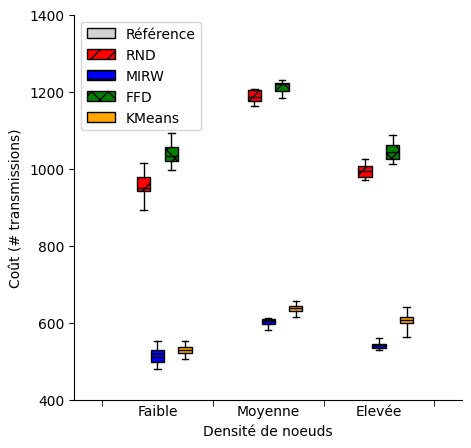

In [143]:
fig, ax = plt.subplots(figsize=(5,5))
bp0 = box_plot(datasets, 0, 'lightgray')
bp1 = box_plot(datasets, 1, 'red', hatch_pattern='//')
bp2 = box_plot(datasets, 2, 'blue', hatch_pattern='--')
bp3 = box_plot(datasets, 3, 'green', hatch_pattern='xx')
bp4 = box_plot(datasets, 4, 'orange', hatch_pattern=None)

plt.xticks(np.arange(len(list(datasets[0]))) + 1)
plt.gca().xaxis.set_minor_locator(ticker.FixedLocator(
    np.array(range(len(list(datasets[0])) + 1)) + 0.5)
)
plt.gca().tick_params(axis='x', which='minor', length=4)
plt.gca().tick_params(axis='x', which='major', length=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(
    [bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], 
    ['Référence', 'RND', 'MIRW', 'FFD', 'KMeans'], 
    loc='upper left')
ax.set_ylim(400, 1400)
ax.set_ylabel('Coût (# transmissions)')
ax.set_xlabel('Densité de noeuds')

Text(0.5, 0, 'Densité de noeuds')

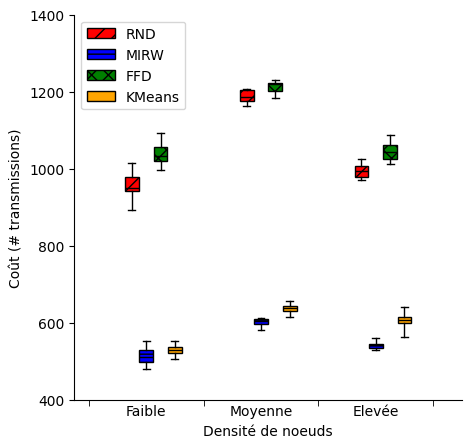

In [144]:
# RCost
fig, ax = plt.subplots(figsize=(5,5))
bp1 = box_plot(datasets, 1, 'red', hatch_pattern='//')
bp2 = box_plot(datasets, 2, 'blue', hatch_pattern='--')
bp3 = box_plot(datasets, 3, 'green', hatch_pattern='xx')
bp4 = box_plot(datasets, 4, 'orange', hatch_pattern=None)

plt.xticks(np.arange(len(list(datasets[0]))) + 1)
plt.gca().xaxis.set_minor_locator(ticker.FixedLocator(
    np.array(range(len(list(datasets[0])) + 1)) + 0.5)
)
plt.gca().tick_params(axis='x', which='minor', length=4)
plt.gca().tick_params(axis='x', which='major', length=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(
    [bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], 
    ['RND', 'MIRW', 'FFD', 'KMeans'], 
    loc='upper left')
ax.set_ylim(400, 1400)
ax.set_ylabel('Coût (# transmissions)')
ax.set_xlabel('Densité de noeuds')

## 3. Analyse de la corrélation

In [90]:
df_ref.corr()

,RFlow,RCost,Efficiency,Redundancy,Disparity,Criticity
RFlow,1.000000,0.297881,-0.143140,0.191958,0.159216,0.291608
RCost,0.297881,1.000000,-0.845505,0.391587,-0.160366,0.628136
Efficiency,-0.143140,-0.845505,1.000000,-0.309247,-0.060434,-0.750182
Redundancy,0.191958,0.391587,-0.309247,1.000000,0.382575,0.289843
Disparity,0.159216,-0.160366,-0.060434,0.382575,1.000000,0.157585
Criticity,0.291608,0.628136,-0.750182,0.289843,0.157585,1.000000


In [33]:
df_rnd.corr()

,RFlow,RCost,Efficiency,Redundancy,Disparity,Criticity
RFlow,1.000000,0.287728,-0.150553,0.189443,0.189791,0.163870
RCost,0.287728,1.000000,-0.857474,0.375252,-0.177076,0.634683
Efficiency,-0.150553,-0.857474,1.000000,-0.290135,-0.008084,-0.548682
Redundancy,0.189443,0.375252,-0.290135,1.000000,0.387723,0.310361
Disparity,0.189791,-0.177076,-0.008084,0.387723,1.000000,-0.058079
Criticity,0.163870,0.634683,-0.548682,0.310361,-0.058079,1.000000
